# Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error
import xgboost as xgb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
%matplotlib inline

# Import data


In [2]:
df = pd.read_csv(r'all_stocks_5yr.csv')
df.head(5)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


Basic description of the data

In [3]:
df.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


In [4]:
print(f"The shape of the data is: {df.shape}")
df.info()

The shape of the data is: (619040, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [5]:
n = len(pd.unique(df['Name']))
  
print("Number of stocks:", 
      n)

Number of stocks: 505


As there is just too many different stocks from different industries I limit the investigation to a focus area. Which I have chosen to be the energy industry. I have downloaded a list of energy companies and use that to analyze the data and build my models.

In [6]:
energy_comps = pd.read_csv(r'energy_companies.csv')
energy_comps.head(5)

,Energy
0,XOM
1,CVX
2,SHEL
3,TTE
4,COP


In [7]:
df = df[df['Name'].isin(energy_comps['Energy'])]

In [8]:
n = len(pd.unique(df['Name']))
  
print("Number of stocks:", 
      n)

Number of stocks: 5


In [9]:
companies = pd.unique(df['Name']).tolist()
companies

['COP', 'CVX', 'EOG', 'SLB', 'XOM']

Only the above 5 are available in both lists so I will use these.

# Data analysis

First we want to investigate the relationship of the companies to each other.

Create a separate dataframe for each investigated company.

In [10]:
company_df = []
for i, company in enumerate(companies):
    company_df.append(df[(df.Name == company)])


Plot the opening and closing prices for each stocks during the investigated timeperiod, to check if we see a trend.

<Figure size 720x3600 with 0 Axes>

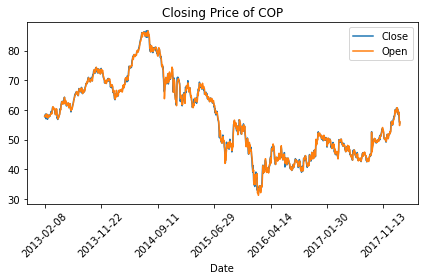

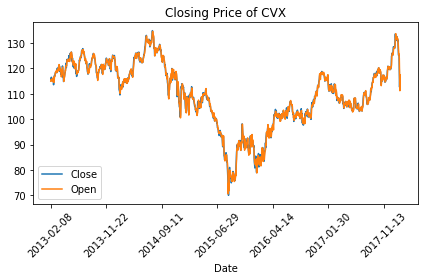

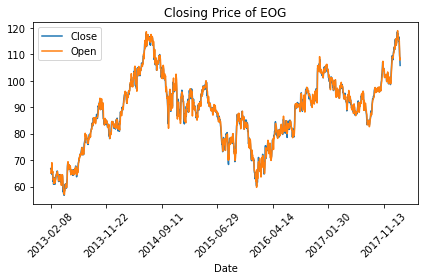

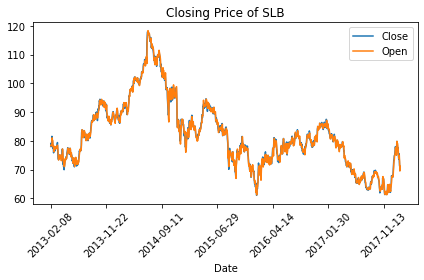

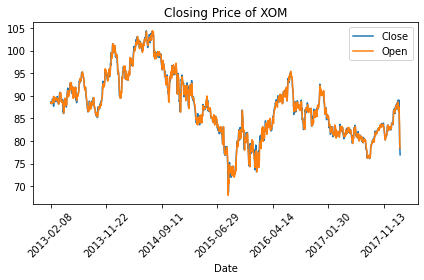

In [11]:
plt.figure(figsize=(10, 50))

for i,j in enumerate(company_df,1):
    company_df[i-1].plot(x ='date', y =['close','open'], label = ['Close','Open'])
    plt.xlabel('Date')
    plt.title(f"Closing Price of {company_df[i-1]['Name'].iloc[0]}")
    plt.xticks(rotation=45)
    plt.tight_layout()

Not much, but e.g. we can see that all decreased in 2014-2015 and increased afterwards. That maybe indicate that they are somehow correlated.

Create a dataframe which contains only e.g. the closing prices for each company (and the date of the given data). And plot them in one figure.

In [12]:
closing_data = []
for i in range(len(company_df)):
    closing_data.append(company_df[i]['close'].tolist())
closings = pd.DataFrame()
for i in range(len(closing_data)):
    closings[companies[i]] = closing_data[i]

closings['date'] = company_df[0]['date'].tolist()
closings.head(10)


,COP,CVX,EOG,SLB,XOM,date
0,57.87,115.64,66.640,79.07,88.61,2013-02-08
1,57.59,115.64,66.670,77.93,88.28,2013-02-11
2,58.25,116.50,67.050,78.53,88.46,2013-02-12
3,58.61,115.53,66.800,78.63,88.67,2013-02-13
4,57.92,115.71,66.665,81.56,88.52,2013-02-14
5,57.02,114.96,64.595,80.03,88.36,2013-02-15
6,58.60,115.92,65.700,79.99,89.32,2013-02-19
7,57.67,114.99,63.695,78.53,88.97,2013-02-20
8,58.11,114.99,62.020,77.43,88.59,2013-02-21
9,58.20,115.96,62.670,77.79,89.20,2013-02-22


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.]),
 [Text(-200.0, 0, '2017-04-25'),
  Text(0.0, 0, '2013-02-08'),
  Text(200.0, 0, '2013-11-22'),
  Text(400.0, 0, '2014-09-11'),
  Text(600.0, 0, '2015-06-29'),
  Text(800.0, 0, '2016-04-14'),
  Text(1000.0, 0, '2017-01-30'),
  Text(1200.0, 0, '2017-11-13'),
  Text(1400.0, 0, '')])

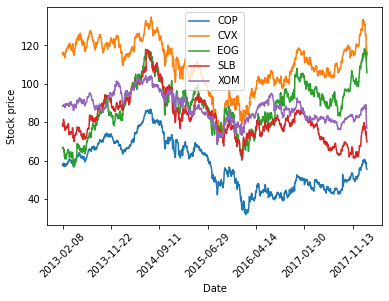

In [13]:
closings.plot(x = 'date', y =companies, label = companies)
plt.xlabel('Date')
plt.ylabel('Stock price')
plt.xticks(rotation=45)

That plot confirms that these stocks move quite closely together (but not on the same level), lets see them on a pairplot.

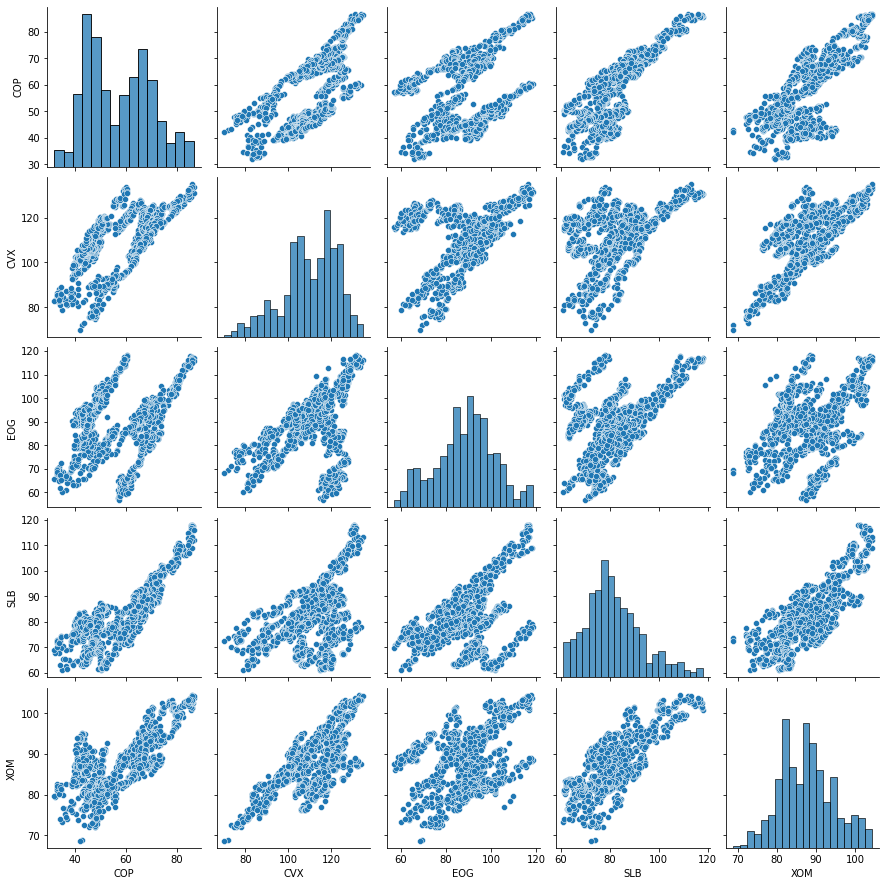

In [14]:
sns.pairplot(closings)

Based on the pairplots it seems like there is a relationship between the stock prices of the different energy companies. (They are affected with the same impacts.) Let's see the effect on a correlation plot.

<AxesSubplot:>

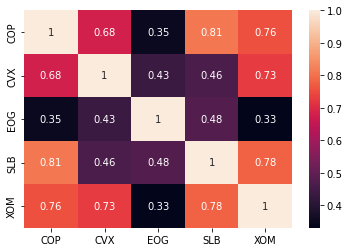

In [15]:
sns.heatmap(closings.corr(), annot=True)

Based on that we may conclude that by only predicting one of them, we can possibly estimate the others too. 

Another idea is to check if the traded volume is in relationship with the daily price difference. (Probably with the absolute difference.) 

In [16]:
df['diff'] = df['close'] - df['open']
df['abs_diff'] = abs(df['diff'])
df['diff_norm'] = (df['diff']-df['diff'].min())/(df['diff'].max()-df['diff'].min())
df['abs_diff_norm'] = (df['abs_diff']-df['abs_diff'].min())/(df['abs_diff'].max()-df['abs_diff'].min())
df['vol_norm'] = (df['volume']-df['volume'].min())/(df['volume'].max()-df['volume'].min())
df.head(5)

,date,open,high,low,close,volume,Name,diff,abs_diff,diff_norm,abs_diff_norm,vol_norm
138222,2013-02-08,57.82,57.87,57.5800,57.87,17871725,COP,0.05,0.05,0.439334,0.007022,0.297039
138223,2013-02-11,57.94,57.94,57.5300,57.59,19329629,COP,-0.35,0.35,0.407613,0.049157,0.322575
138224,2013-02-12,57.84,58.26,57.6000,58.25,21826388,COP,0.41,0.41,0.467883,0.057584,0.366309
138225,2013-02-13,58.35,58.62,58.0000,58.61,6787827,COP,0.26,0.26,0.455987,0.036517,0.102894
138226,2013-02-14,57.80,58.01,57.6199,57.92,5764412,COP,0.12,0.12,0.444885,0.016854,0.084968


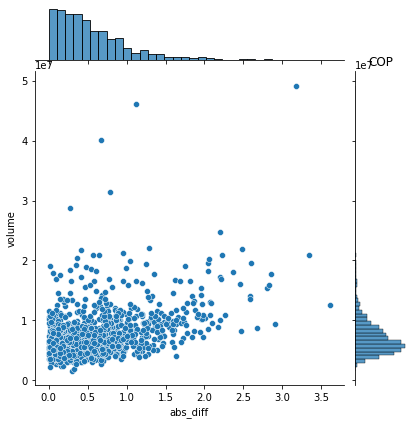

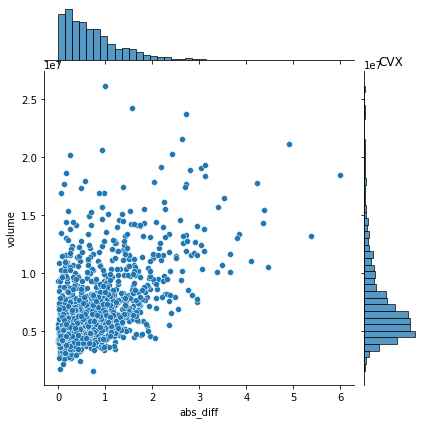

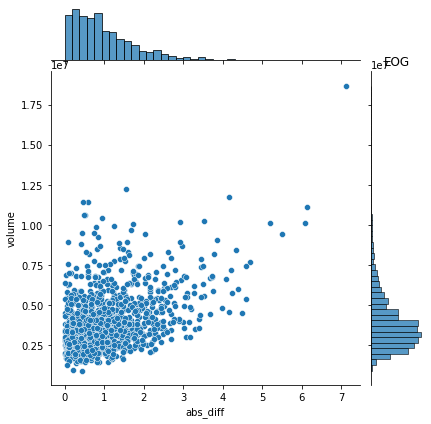

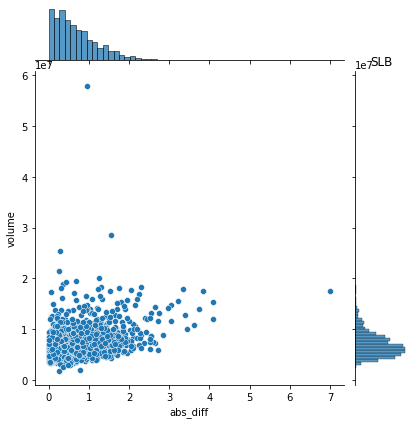

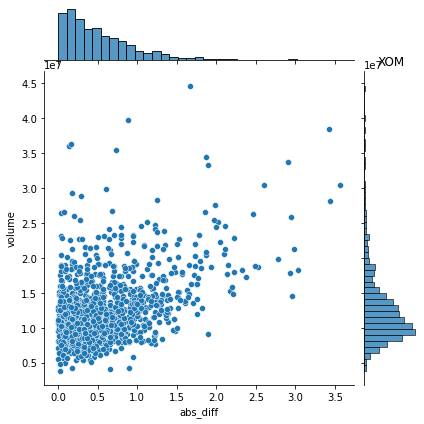

In [17]:
comp_df = []
for i, comp in enumerate(companies):
    comp_df.append(df[(df.Name == comp)])
    #sns.jointplot(x='diff', y='volume', data=comp_df[i], kind='scatter')
    #plt.title(f"{comp_df[i]['Name'].iloc[0]}")
    sns.jointplot(x='abs_diff', y='volume', data=comp_df[i], kind='scatter')
    plt.title(f"{comp_df[i]['Name'].iloc[0]}")

Based on the above figures its seems that there is some correlation between the volume and the absolute value of the daily return of a stock (abs. diff.).

Let's see their histograms plotted on each other (for that I use the normalized values).

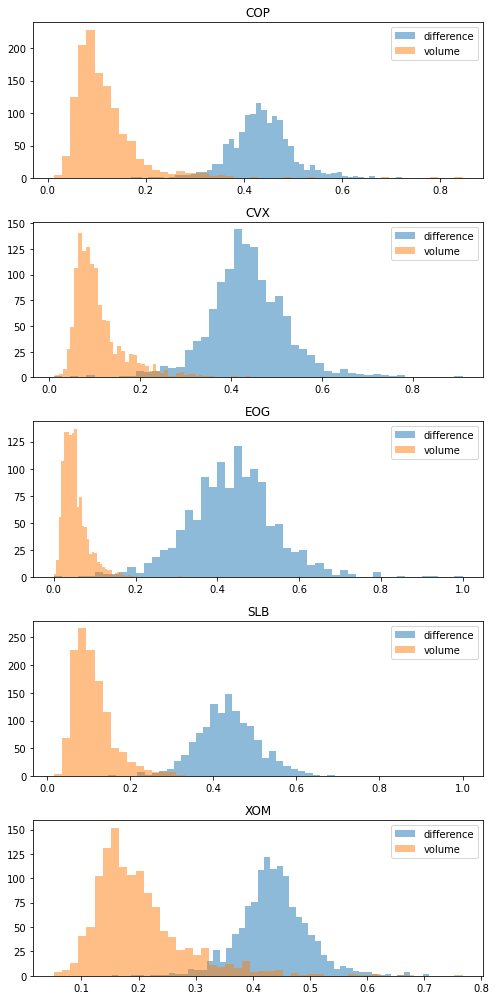

In [18]:
fig, axs = plt.subplots(5, 1, tight_layout=True, figsize=(7, 14))

for i, comp in enumerate(companies):
    comp_df.append(df[(df.Name == company)])
    axs[i].hist(comp_df[i]['diff_norm'], bins=50, alpha=0.5, label='difference')
    axs[i].hist(comp_df[i]['vol_norm'], bins=50, alpha=0.5, label='volume')
    axs[i].legend(loc='upper right')
    axs[i].set_title(comp)
plt.show()



Based on the above we can conclude that it might worth to build a regression model to estimate the return based on the volume. 

Check the correlation between the columns of the dataframe. 

In [19]:
df.corr()

,open,high,low,close,volume,diff,abs_diff,diff_norm,abs_diff_norm,vol_norm
open,1.000000,0.999375,0.999403,0.998748,-0.163223,-0.035089,0.058145,-0.035089,0.058145,-0.163223
high,0.999375,1.000000,0.999171,0.999439,-0.158216,-0.008806,0.075314,-0.008806,0.075314,-0.158216
low,0.999403,0.999171,1.000000,0.999373,-0.167485,-0.010657,0.043512,-0.010657,0.043512,-0.167485
close,0.998748,0.999439,0.999373,1.000000,-0.161589,0.014948,0.060846,0.014948,0.060846,-0.161589
volume,-0.163223,-0.158216,-0.167485,-0.161589,1.000000,0.034293,0.169746,0.034293,0.169746,1.000000
diff,-0.035089,-0.008806,-0.010657,0.014948,0.034293,1.000000,0.053371,1.000000,0.053371,0.034293
abs_diff,0.058145,0.075314,0.043512,0.060846,0.169746,0.053371,1.000000,0.053371,1.000000,0.169746
diff_norm,-0.035089,-0.008806,-0.010657,0.014948,0.034293,1.000000,0.053371,1.000000,0.053371,0.034293
abs_diff_norm,0.058145,0.075314,0.043512,0.060846,0.169746,0.053371,1.000000,0.053371,1.000000,0.169746
vol_norm,-0.163223,-0.158216,-0.167485,-0.161589,1.000000,0.034293,0.169746,0.034293,0.169746,1.000000


Based on that we can say that the difference (especially the abs difference is mostly correlated with the volume.)

# Data cleaning

In [20]:
df.shape

(6295, 12)

Check if there are any NaN values in the data.

In [21]:
count_nan = df.isnull().sum()
print('Number of NaN values present: ' + str(count_nan))

Number of NaN values present: date             0
open             0
high             0
low              0
close            0
volume           0
Name             0
diff             0
abs_diff         0
diff_norm        0
abs_diff_norm    0
vol_norm         0
dtype: int64


The data has no NaN values. 

In [22]:
df.describe()

,open,high,low,close,volume,diff,abs_diff,diff_norm,abs_diff_norm,vol_norm
count,6295.000000,6295.000000,6295.000000,6295.000000,6.295000e+03,6295.000000,6295.000000,6295.000000,6295.000000,6295.000000
mean,85.069960,85.821998,84.283268,85.073386,7.629031e+06,0.003427,0.745217,0.435640,0.104665,0.117628
std,20.461503,20.502066,20.393074,20.451188,4.419483e+06,1.023680,0.701781,0.081180,0.098565,0.077412
min,31.230000,32.380000,31.050000,31.880000,9.135500e+05,-5.490000,0.000000,0.000000,0.000000,0.000000
25%,72.830000,73.510000,72.100000,72.800000,4.658980e+06,-0.550000,0.250000,0.391753,0.035112,0.065605
50%,85.300000,86.100000,84.580000,85.360000,6.557461e+06,-0.010000,0.550000,0.434576,0.077247,0.098859
75%,98.240000,99.175000,97.300000,98.150000,9.529771e+06,0.550000,1.000000,0.478985,0.140449,0.150921
max,134.580000,135.100000,133.690000,134.850000,5.800432e+07,7.120000,7.120000,1.000000,1.000000,1.000000


Based on the above description, the values seems to be realistic and in range.

Lets check fog duplicates in the dates.

In [23]:
sum_of_dupl = 0
for i, comp in enumerate(companies):
    num_of_dupl = sum(comp_df[i]['date'].duplicated())
    sum_of_dupl = sum_of_dupl + num_of_dupl
print(sum_of_dupl)

0


There are no duplicates in the dates. 

The data seems to be appropiate, there is no further need for cleaning (at least that is seeable right now).

# Machine learning models

I will build models for two reasons:
- estimate the daily return based on the volume and the previous values of diff
- predict the closing price of each stocks in the next time steps

## Daily return estimation

### Estimation based on the whole dataset

Data preparation: I have tested many theories, finally the estimates based on the volume and the absolute differences are presented here.

In [24]:
df['high_diff'] = df['high']-df['open']
df['low_diff'] = df['low']-df['open']
df['open_norm'] = (df['open']-df['open'].min())/(df['open'].max()-df['open'].min())
df['close_norm'] = (df['close']-df['close'].min())/(df['close'].max()-df['close'].min())
df['low_norm'] = (df['low']-df['low'].min())/(df['low'].max()-df['low'].min())
df['high_norm'] = (df['high']-df['high'].min())/(df['high'].max()-df['high'].min())
df['prev_diff'] = df['diff']
df['abs_diff_ma_20'] = df['abs_diff'].rolling(20).mean()
df['abs_diff_ma_10'] = df['abs_diff'].rolling(10).mean()
df['abs_diff_ma_5'] = df['abs_diff'].rolling(5).mean()
df['abs_diff_norm_ma_20'] = df['abs_diff_norm'].rolling(20).mean()
df['abs_diff_norm_ma_10'] = df['abs_diff_norm'].rolling(10).mean()
df['abs_diff_norm_ma_5'] = df['abs_diff_norm'].rolling(5).mean()
df.dropna(inplace=True)
df.head(5)


,date,open,high,low,close,volume,Name,diff,abs_diff,diff_norm,...,close_norm,low_norm,high_norm,prev_diff,abs_diff_ma_20,abs_diff_ma_10,abs_diff_ma_5,abs_diff_norm_ma_20,abs_diff_norm_ma_10,abs_diff_norm_ma_5
138241,2013-03-08,57.97,58.490,57.83,58.39,4797968,COP,0.42,0.42,0.468676,...,0.257454,0.260912,0.254186,0.42,0.4476,0.4342,0.2864,0.062865,0.060983,0.040225
138242,2013-03-11,58.41,58.595,58.08,58.44,4725968,COP,0.03,0.03,0.437748,...,0.257939,0.263348,0.255208,0.03,0.4466,0.2792,0.1884,0.062725,0.039213,0.026461
138243,2013-03-12,58.56,58.920,58.45,58.73,4664590,COP,0.17,0.17,0.448850,...,0.260756,0.266952,0.258372,0.17,0.4376,0.2512,0.1664,0.061461,0.035281,0.023371
138244,2013-03-13,58.76,58.940,58.56,58.78,4485313,COP,0.02,0.02,0.436955,...,0.261241,0.268024,0.258567,0.02,0.4181,0.2052,0.1564,0.058722,0.028820,0.021966
138245,2013-03-14,59.00,59.560,58.87,59.52,5130118,COP,0.52,0.52,0.476606,...,0.268428,0.271044,0.264603,0.52,0.4311,0.2522,0.2320,0.060548,0.035421,0.032584


In [25]:
df.corr()

,open,high,low,close,volume,diff,abs_diff,diff_norm,abs_diff_norm,vol_norm,...,close_norm,low_norm,high_norm,prev_diff,abs_diff_ma_20,abs_diff_ma_10,abs_diff_ma_5,abs_diff_norm_ma_20,abs_diff_norm_ma_10,abs_diff_norm_ma_5
open,1.000000,0.999373,0.999400,0.998743,-0.162836,-0.035409,0.056637,-0.035409,0.056637,-0.162836,...,0.998743,0.999400,0.999373,-0.035409,0.126373,0.115743,0.096014,0.126373,0.115743,0.096014
high,0.999373,1.000000,0.999168,0.999437,-0.157798,-0.009064,0.073841,-0.009064,0.073841,-0.157798,...,0.999437,0.999168,1.000000,-0.009064,0.137923,0.127885,0.109873,0.137923,0.127885,0.109873
low,0.999400,0.999168,1.000000,0.999371,-0.167129,-0.010926,0.041989,-0.010926,0.041989,-0.167129,...,0.999371,1.000000,0.999168,-0.010926,0.113649,0.102921,0.082836,0.113649,0.102921,0.082836
close,0.998743,0.999437,0.999371,1.000000,-0.161198,0.014737,0.059367,0.014737,0.059367,-0.161198,...,1.000000,0.999371,0.999437,0.014737,0.127163,0.117095,0.098461,0.127163,0.117095,0.098461
volume,-0.162836,-0.157798,-0.167129,-0.161198,1.000000,0.034335,0.170646,0.034335,0.170646,1.000000,...,-0.161198,-0.167129,-0.157798,0.034335,-0.031587,0.026465,0.106653,-0.031587,0.026465,0.106653
diff,-0.035409,-0.009064,-0.010926,0.014737,0.034335,1.000000,0.053838,1.000000,0.053838,0.034335,...,0.014737,-0.010926,-0.009064,1.000000,0.014433,0.025749,0.047774,0.014433,0.025749,0.047774
abs_diff,0.056637,0.073841,0.041989,0.059367,0.170646,0.053838,1.000000,0.053838,1.000000,0.170646,...,0.059367,0.041989,0.073841,0.053838,0.415695,0.476255,0.584934,0.415695,0.476255,0.584934
diff_norm,-0.035409,-0.009064,-0.010926,0.014737,0.034335,1.000000,0.053838,1.000000,0.053838,0.034335,...,0.014737,-0.010926,-0.009064,1.000000,0.014433,0.025749,0.047774,0.014433,0.025749,0.047774
abs_diff_norm,0.056637,0.073841,0.041989,0.059367,0.170646,0.053838,1.000000,0.053838,1.000000,0.170646,...,0.059367,0.041989,0.073841,0.053838,0.415695,0.476255,0.584934,0.415695,0.476255,0.584934
vol_norm,-0.162836,-0.157798,-0.167129,-0.161198,1.000000,0.034335,0.170646,0.034335,0.170646,1.000000,...,-0.161198,-0.167129,-0.157798,0.034335,-0.031587,0.026465,0.106653,-0.031587,0.026465,0.106653


In [26]:
X=df[['volume','abs_diff_ma_20','abs_diff_ma_10','abs_diff_ma_5']]
y = df['abs_diff']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


I have chosen 4 different models to estimate the absuolute difference: linear, bayesian, logistic regression and XGBoost regression.

#### Linear regression

In [27]:
regressor_lin = LinearRegression()
regressor_lin.fit(X_train, y_train)
print(regressor_lin.intercept_)
print(regressor_lin.coef_)

-0.12958597234141822
[ 1.79467465e-08  1.14385269e-01 -1.55550591e-01  1.02601832e+00]


In [28]:
y_pred = regressor_lin.predict(X_test)
result_lin = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
result_lin

,Actual,Predicted
197212,0.01,1.303021
197426,0.98,0.710433
154101,0.86,0.628079
197232,2.30,1.226050
197326,2.08,1.362821
...,...,...
138513,0.76,0.528763
154912,2.06,0.618054
609293,0.25,0.417977
197218,1.61,0.880285


In [29]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
MSE_linear = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', MSE_linear)

Mean Absolute Error: 0.4028502378501986
Mean Squared Error: 0.3156408604861826
Root Mean Squared Error: 0.5618192418262146


#### Bayesian regression

In [30]:
regressor_bay = linear_model.BayesianRidge()
regressor_bay.fit(X_train, y_train)
regressor_bay.coef_

array([ 1.79822614e-08,  1.11653041e-01, -1.47664681e-01,  1.02048525e+00])

In [31]:
y_pred=regressor_bay.predict(X_test)
result_bay = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
result_bay

,Actual,Predicted
197212,0.01,1.301656
197426,0.98,0.710723
154101,0.86,0.628614
197232,2.30,1.227461
197326,2.08,1.361736
...,...,...
138513,0.76,0.528599
154912,2.06,0.617652
609293,0.25,0.418027
197218,1.61,0.881132


In [32]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
MSE_bayesian = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', MSE_bayesian)

Mean Absolute Error: 0.4028829103164489
Mean Squared Error: 0.31563280489313605
Root Mean Squared Error: 0.5618120725768858


#### XGBoost regression

In [33]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.5,
                max_depth = 2, alpha = 10, n_estimators = 5)

In [34]:
xg_reg.fit(X_train,y_train)

y_pred = xg_reg.predict(X_test)

In [35]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.578692


In [36]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
MSE_XGB = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', MSE_XGB)

Mean Absolute Error: 0.4222031940264685
Mean Squared Error: 0.3348840210418576
Root Mean Squared Error: 0.5786916459063994


#### Logistic regression

In [37]:
formula = 'diff ~ volume+abs_diff_ma_20+abs_diff_ma_10+abs_diff_ma_5'

In [38]:
model_log_reg = smf.glm(formula = formula, data=df, family=sm.families.Binomial())
fit_log = model_log_reg.fit()
print(fit_log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   diff   No. Observations:                 6276
Model:                            GLM   Df Residuals:                     6271
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Thu, 22 Dec 2022   Deviance:                   4.3104e+05
Time:                        22:13:21   Pearson chi2:                 2.96e+19
No. Iterations:                    42   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2.792e+15   2.71e+06  -1.03e

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1014: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1014: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1013: RuntimeWarning: invalid value encountered in add
  special.gammaln(n + 1) - special.gammaln(y + 1) -
c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [39]:
ypred = fit_log.predict(X_test)
result_log = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
result_log

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


,Actual,Predicted
197212,0.01,1.023585
197426,0.98,0.753420
154101,0.86,0.709123
197232,2.30,1.128430
197326,2.08,1.023585
...,...,...
138513,0.76,0.605627
154912,2.06,0.636977
609293,0.25,0.420901
197218,1.61,0.786925


In [40]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
MSE_log = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', MSE_log)

Mean Absolute Error: 0.4222031940264685
Mean Squared Error: 0.3348840210418576
Root Mean Squared Error: 0.5786916459063994


In [41]:
df.describe()

,open,high,low,close,volume,diff,abs_diff,diff_norm,abs_diff_norm,vol_norm,...,close_norm,low_norm,high_norm,prev_diff,abs_diff_ma_20,abs_diff_ma_10,abs_diff_ma_5,abs_diff_norm_ma_20,abs_diff_norm_ma_10,abs_diff_norm_ma_5
count,6276.000000,6276.000000,6276.000000,6276.000000,6.276000e+03,6276.000000,6276.000000,6276.000000,6276.000000,6276.000000,...,6276.000000,6276.000000,6276.000000,6276.000000,6276.000000,6276.000000,6276.000000,6276.000000,6276.000000,6276.000000
mean,85.152083,85.905584,84.364496,85.155685,7.625267e+06,0.003601,0.746113,0.435654,0.104791,0.117562,...,0.517390,0.519432,0.521082,0.003601,0.745346,0.745394,0.745720,0.104683,0.104690,0.104736
std,20.437849,20.476623,20.370323,20.427251,4.417537e+06,1.024709,0.702330,0.081262,0.098642,0.077377,...,0.198381,0.198464,0.199344,1.024709,0.307643,0.351692,0.416584,0.043208,0.049395,0.058509
min,31.230000,32.380000,31.050000,31.880000,9.135500e+05,-5.490000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-5.490000,0.202750,0.170000,0.086000,0.028476,0.023876,0.012079
25%,73.097500,73.597500,72.200000,72.926250,4.655740e+06,-0.560000,0.250000,0.390960,0.035112,0.065548,...,0.398623,0.400916,0.401261,-0.560000,0.527000,0.499000,0.454000,0.074017,0.070084,0.063764
50%,85.350000,86.145000,84.650000,85.430000,6.551058e+06,-0.010000,0.550000,0.434576,0.077247,0.098746,...,0.520054,0.522214,0.523413,-0.010000,0.673997,0.668000,0.652000,0.094663,0.093820,0.091573
75%,98.277500,99.202500,97.450000,98.262500,9.531330e+06,0.550000,1.000000,0.478985,0.140449,0.150949,...,0.644678,0.646921,0.650531,0.550000,0.907500,0.911248,0.936000,0.127458,0.127984,0.131461
max,134.580000,135.100000,133.690000,134.850000,5.800432e+07,7.120000,7.120000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,7.120000,2.479000,3.267000,4.450000,0.348174,0.458848,0.625000


### Conclusion

In [42]:
print('Linear:',MSE_linear, 'Bayesian:',MSE_bayesian,'XGBoost:',MSE_XGB,'Logistic:',MSE_log)
print('Absolute daily return mean value:',df['abs_diff'].mean())
print('Error ratio:',MSE_linear/df['abs_diff'].mean())

Linear: 0.5618192418262146 Bayesian: 0.5618120725768858 XGBoost: 0.5786916459063994 Logistic: 0.5786916459063994
Absolute daily return mean value: 0.7461132249840701
Error ratio: 0.7529946166524655


It can be seen that the previously applied models give quite a bad estimate of the daily return as their error is in the same magnitude as the mean value of the daily return. 

### Estimation based on all stock but with normalized values

In [43]:
X=df[['vol_norm','abs_diff_norm_ma_20','abs_diff_norm_ma_10','abs_diff_norm_ma_5']]
y = df['abs_diff_norm']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Linear regression

In [44]:
regressor_lin = LinearRegression()
regressor_lin.fit(X_train, y_train)
print(regressor_lin.intercept_)
print(regressor_lin.coef_)
y_pred = regressor_lin.predict(X_test)
result_lin = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
MSE_linear = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', MSE_linear)

-0.0158975733298979
[ 0.1439036   0.11438527 -0.15555059  1.02601832]
Mean Absolute Error: 0.05658008958570212
Mean Squared Error: 0.006226345720359319
Root Mean Squared Error: 0.07890719688570441


#### Bayesian regression

In [45]:
regressor_bay = linear_model.BayesianRidge()
regressor_bay.fit(X_train, y_train)
y_pred=regressor_bay.predict(X_test)
result_bay = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
MSE_bayesian = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', MSE_bayesian)

Mean Absolute Error: 0.056584224898129386
Mean Squared Error: 0.006226162065930826
Root Mean Squared Error: 0.07890603314025377


#### XGBoost

In [46]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.5,
                max_depth = 2, alpha = 10, n_estimators = 5)
xg_reg.fit(X_train,y_train)
y_pred = xg_reg.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
MSE_XGB = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', MSE_XGB)

Mean Absolute Error: 0.06494741053097788
Mean Squared Error: 0.007220494526166214
Root Mean Squared Error: 0.0849734930797023


#### Logistic regression

In [47]:
formula = 'diff ~ volume+abs_diff_ma_20+abs_diff_ma_10+abs_diff_ma_5'
model_log_reg = smf.glm(formula = formula, data=df, family=sm.families.Binomial())
fit_log = model_log_reg.fit()
print(fit_log.summary())
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
MSE_log = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', MSE_log)

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1014: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1014: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1013: RuntimeWarning: invalid value encountered in add
  special.gammaln(n + 1) - special.gammaln(y + 1) -
c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                   diff   No. Observations:                 6276
Model:                            GLM   Df Residuals:                     6271
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Thu, 22 Dec 2022   Deviance:                   4.3104e+05
Time:                        22:13:23   Pearson chi2:                 2.96e+19
No. Iterations:                    42   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2.792e+15   2.71e+06  -1.03e

### Conclusion

In [48]:
print('Linear:',MSE_linear, 'Bayesian:',MSE_bayesian,'XGBoost:',MSE_XGB,'Logistic:',MSE_log)
print('Absolute daily return mean value:',df['abs_diff_norm'].mean())
print('Error ratio:',MSE_linear/df['abs_diff_norm'].mean())

Linear: 0.07890719688570441 Bayesian: 0.07890603314025377 XGBoost: 0.0849734930797023 Logistic: 0.0849734930797023
Absolute daily return mean value: 0.10479118328427907
Error ratio: 0.7529946166524697


Normalization does not really help, the estimation is still quite bad.

### Estimation based on only one stock

Split dataframe for companies

In [49]:
company_df = []
for i, company in enumerate(companies):
    company_df.append(df[(df.Name == company)])

In [50]:
X=company_df[0][['volume','abs_diff_ma_20','abs_diff_ma_10','abs_diff_ma_5']]
y = company_df[0]['abs_diff']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Linear regression

In [51]:
regressor_lin = LinearRegression()
regressor_lin.fit(X_train, y_train)
print(regressor_lin.intercept_)
print(regressor_lin.coef_)
y_pred = regressor_lin.predict(X_test)
result_lin = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
MSE_linear = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', MSE_linear)

-0.028349767550638116
[ 2.78131872e-08  4.68391147e-02 -3.32335680e-01  1.00029837e+00]
Mean Absolute Error: 0.28056435699283255
Mean Squared Error: 0.13794670167783613
Root Mean Squared Error: 0.37141176836206485


#### Bayesian regression

In [52]:
regressor_bay = linear_model.BayesianRidge()
regressor_bay.fit(X_train, y_train)
y_pred=regressor_bay.predict(X_test)
result_bay = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
MSE_bayesian = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', MSE_bayesian)

Mean Absolute Error: 0.28051986880590224
Mean Squared Error: 0.13771292024064974
Root Mean Squared Error: 0.37109691488969526


#### XGBoost

In [53]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.5,
                max_depth = 2, alpha = 10, n_estimators = 5)
xg_reg.fit(X_train,y_train)
y_pred = xg_reg.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
MSE_XGB = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', MSE_XGB)

Mean Absolute Error: 0.29759856389414885
Mean Squared Error: 0.15530839769584573
Root Mean Squared Error: 0.3940918645390256


#### Logistic regression

In [54]:
formula = 'diff ~ volume+abs_diff_ma_20+abs_diff_ma_10+abs_diff_ma_5'
model_log_reg = smf.glm(formula = formula, data=df, family=sm.families.Binomial())
fit_log = model_log_reg.fit()
print(fit_log.summary())
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
MSE_log = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', MSE_log)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   diff   No. Observations:                 6276
Model:                            GLM   Df Residuals:                     6271
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Thu, 22 Dec 2022   Deviance:                   4.3104e+05
Time:                        22:13:23   Pearson chi2:                 2.96e+19
No. Iterations:                    42   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2.792e+15   2.71e+06  -1.03e

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1014: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1014: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:1013: RuntimeWarning: invalid value encountered in add
  special.gammaln(n + 1) - special.gammaln(y + 1) -
c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


### Conclusion

In [55]:
print('Linear:',MSE_linear, 'Bayesian:',MSE_bayesian,'XGBoost:',MSE_XGB,'Logistic:',MSE_log)
print('Absolute daily return mean value:',company_df[0]['abs_diff'].mean())
print('Error ratio:',MSE_linear/company_df[0]['abs_diff'].mean())

Linear: 0.37141176836206485 Bayesian: 0.37109691488969526 XGBoost: 0.3940918645390256 Logistic: 0.3940918645390256
Absolute daily return mean value: 0.586637096774193
Error ratio: 0.6331201528242729


It is hardly dependent on the stock whether the error rate is improving or not, but in general, still the estimation is quite bad.

## Closing price prediction for one stock

I want to make a model, which is predicting the closing price of a stock only based on the previous colsing values of that stock. For that recurrent neural networks are the best based on the literature. They have an improved version called long short-term memory neural network (LSTM) which is used for times series forecasting. I will use that on the first stock.

Plot it again. 

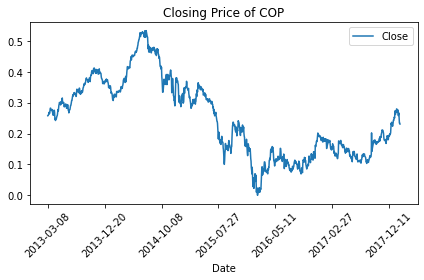

In [56]:
company_df[0].plot(x ='date', y =['close_norm'], label = ['Close'])
plt.xlabel('Date')
plt.title(f"Closing Price of {company_df[0]['Name'].iloc[0]}")
plt.xticks(rotation=45)
plt.tight_layout()

I will use the older 90% of the data to predict the last 10%. 

In [57]:
closing_norm_data = company_df[0].filter(['close_norm'])
dataset_values = closing_norm_data.values
training_data_len = int(np.ceil( len(dataset_values) * .90 ))
train_data = dataset_values[0:int(training_data_len),:]


I need to input the data in the form of a 3D array to the LSTM model. Lets take a 100 previous values to train the current one.

In [58]:
X_train = []
y_train = []
for i in range(100, training_data_len):
    X_train.append(train_data[i-100:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

#### Model training 
As I am not familiar with LSTM neural networks I picked up the layers randomly. (Made some iteration with them to get good results at the end.) ADAM optimizer and MSE loss was proposed in the literature for such time series. 

In [59]:
model = Sequential()
model.add(LSTM(units=30,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(units=30,return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=30))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=10,batch_size=10)

Epoch 1/10
102/102 [==============================] - 47s 232ms/step - loss: 0.0061
Epoch 2/10
102/102 [==============================] - 23s 225ms/step - loss: 0.0014
Epoch 3/10
102/102 [==============================] - 16s 155ms/step - loss: 0.0013
Epoch 4/10
102/102 [==============================] - 15s 150ms/step - loss: 0.0011
Epoch 5/10
102/102 [==============================] - 14s 141ms/step - loss: 0.0012
Epoch 6/10
102/102 [==============================] - 15s 150ms/step - loss: 0.0010
Epoch 7/10
102/102 [==============================] - 16s 156ms/step - loss: 0.0010
Epoch 8/10
102/102 [==============================] - 16s 152ms/step - loss: 9.7726e-04
Epoch 9/10
102/102 [==============================] - 15s 149ms/step - loss: 9.3029e-04
Epoch 10/10
102/102 [==============================] - 15s 149ms/step - loss: 8.9377e-04


In [60]:
X_test = []
test_data = dataset_values[int(training_data_len)-100:, :]
for i in range(100, len(test_data)):
    X_test.append(test_data[i-100:i, 0])

# Reshaping to fit into the requested format
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))
# Do the predictions
predictions = model.predict(X_test)
# Printing a errors
print('Mean Absolute Error:', metrics.mean_absolute_error(test_data[100:], predictions))
print('Mean Squared Error:', metrics.mean_squared_error(test_data[100:], predictions))
MSE_RNN = np.sqrt(metrics.mean_squared_error(test_data[100:], predictions))
print('Root Mean Squared Error:', MSE_RNN)

4/4 [==============================] - 2s 63ms/step
Mean Absolute Error: 0.014926414054722259
Mean Squared Error: 0.00033223600885601225
Root Mean Squared Error: 0.018227342342097278


The root mean squared error is much lower then the best achived with regression models: 0.07890719688570441

It can be seen that the errors are much lower then in case of any previously used models.

C:\Users\Admin\AppData\Local\Temp\ipykernel_2376\2512545137.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


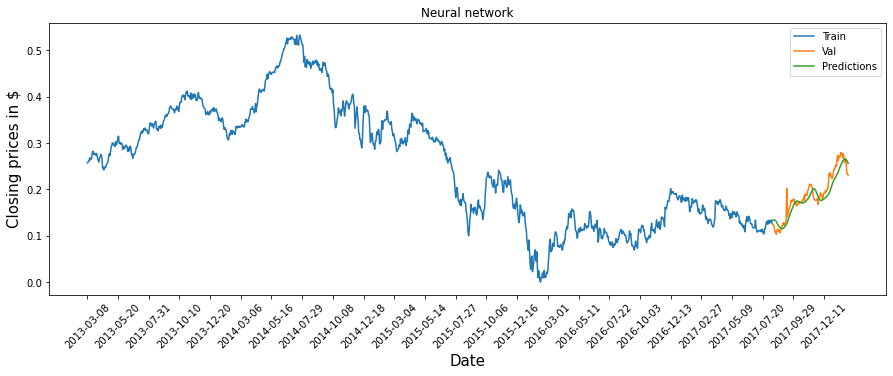

In [61]:
train = closing_norm_data[:training_data_len]
test = closing_norm_data[training_data_len:]
test['Predictions'] = predictions
plt.figure(figsize=(15,5))
plt.title('Neural network')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Closing prices in $', fontsize=15)
plt.plot(train)
plt.plot(test[['close_norm','Predictions']])
tickvalues = closing_norm_data.index[::50]
labellist = company_df[0]['date'].values[::50]
plt.xticks(ticks = tickvalues ,labels = labellist, rotation=45)
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()

## Conclusion

The last NN based solution showed quite promising results. 